# Analyzing Crowdsourced Moral Judgments in Online Discourse

*Rachel Montgomery*

## Introduction

italicized text![reddit.png](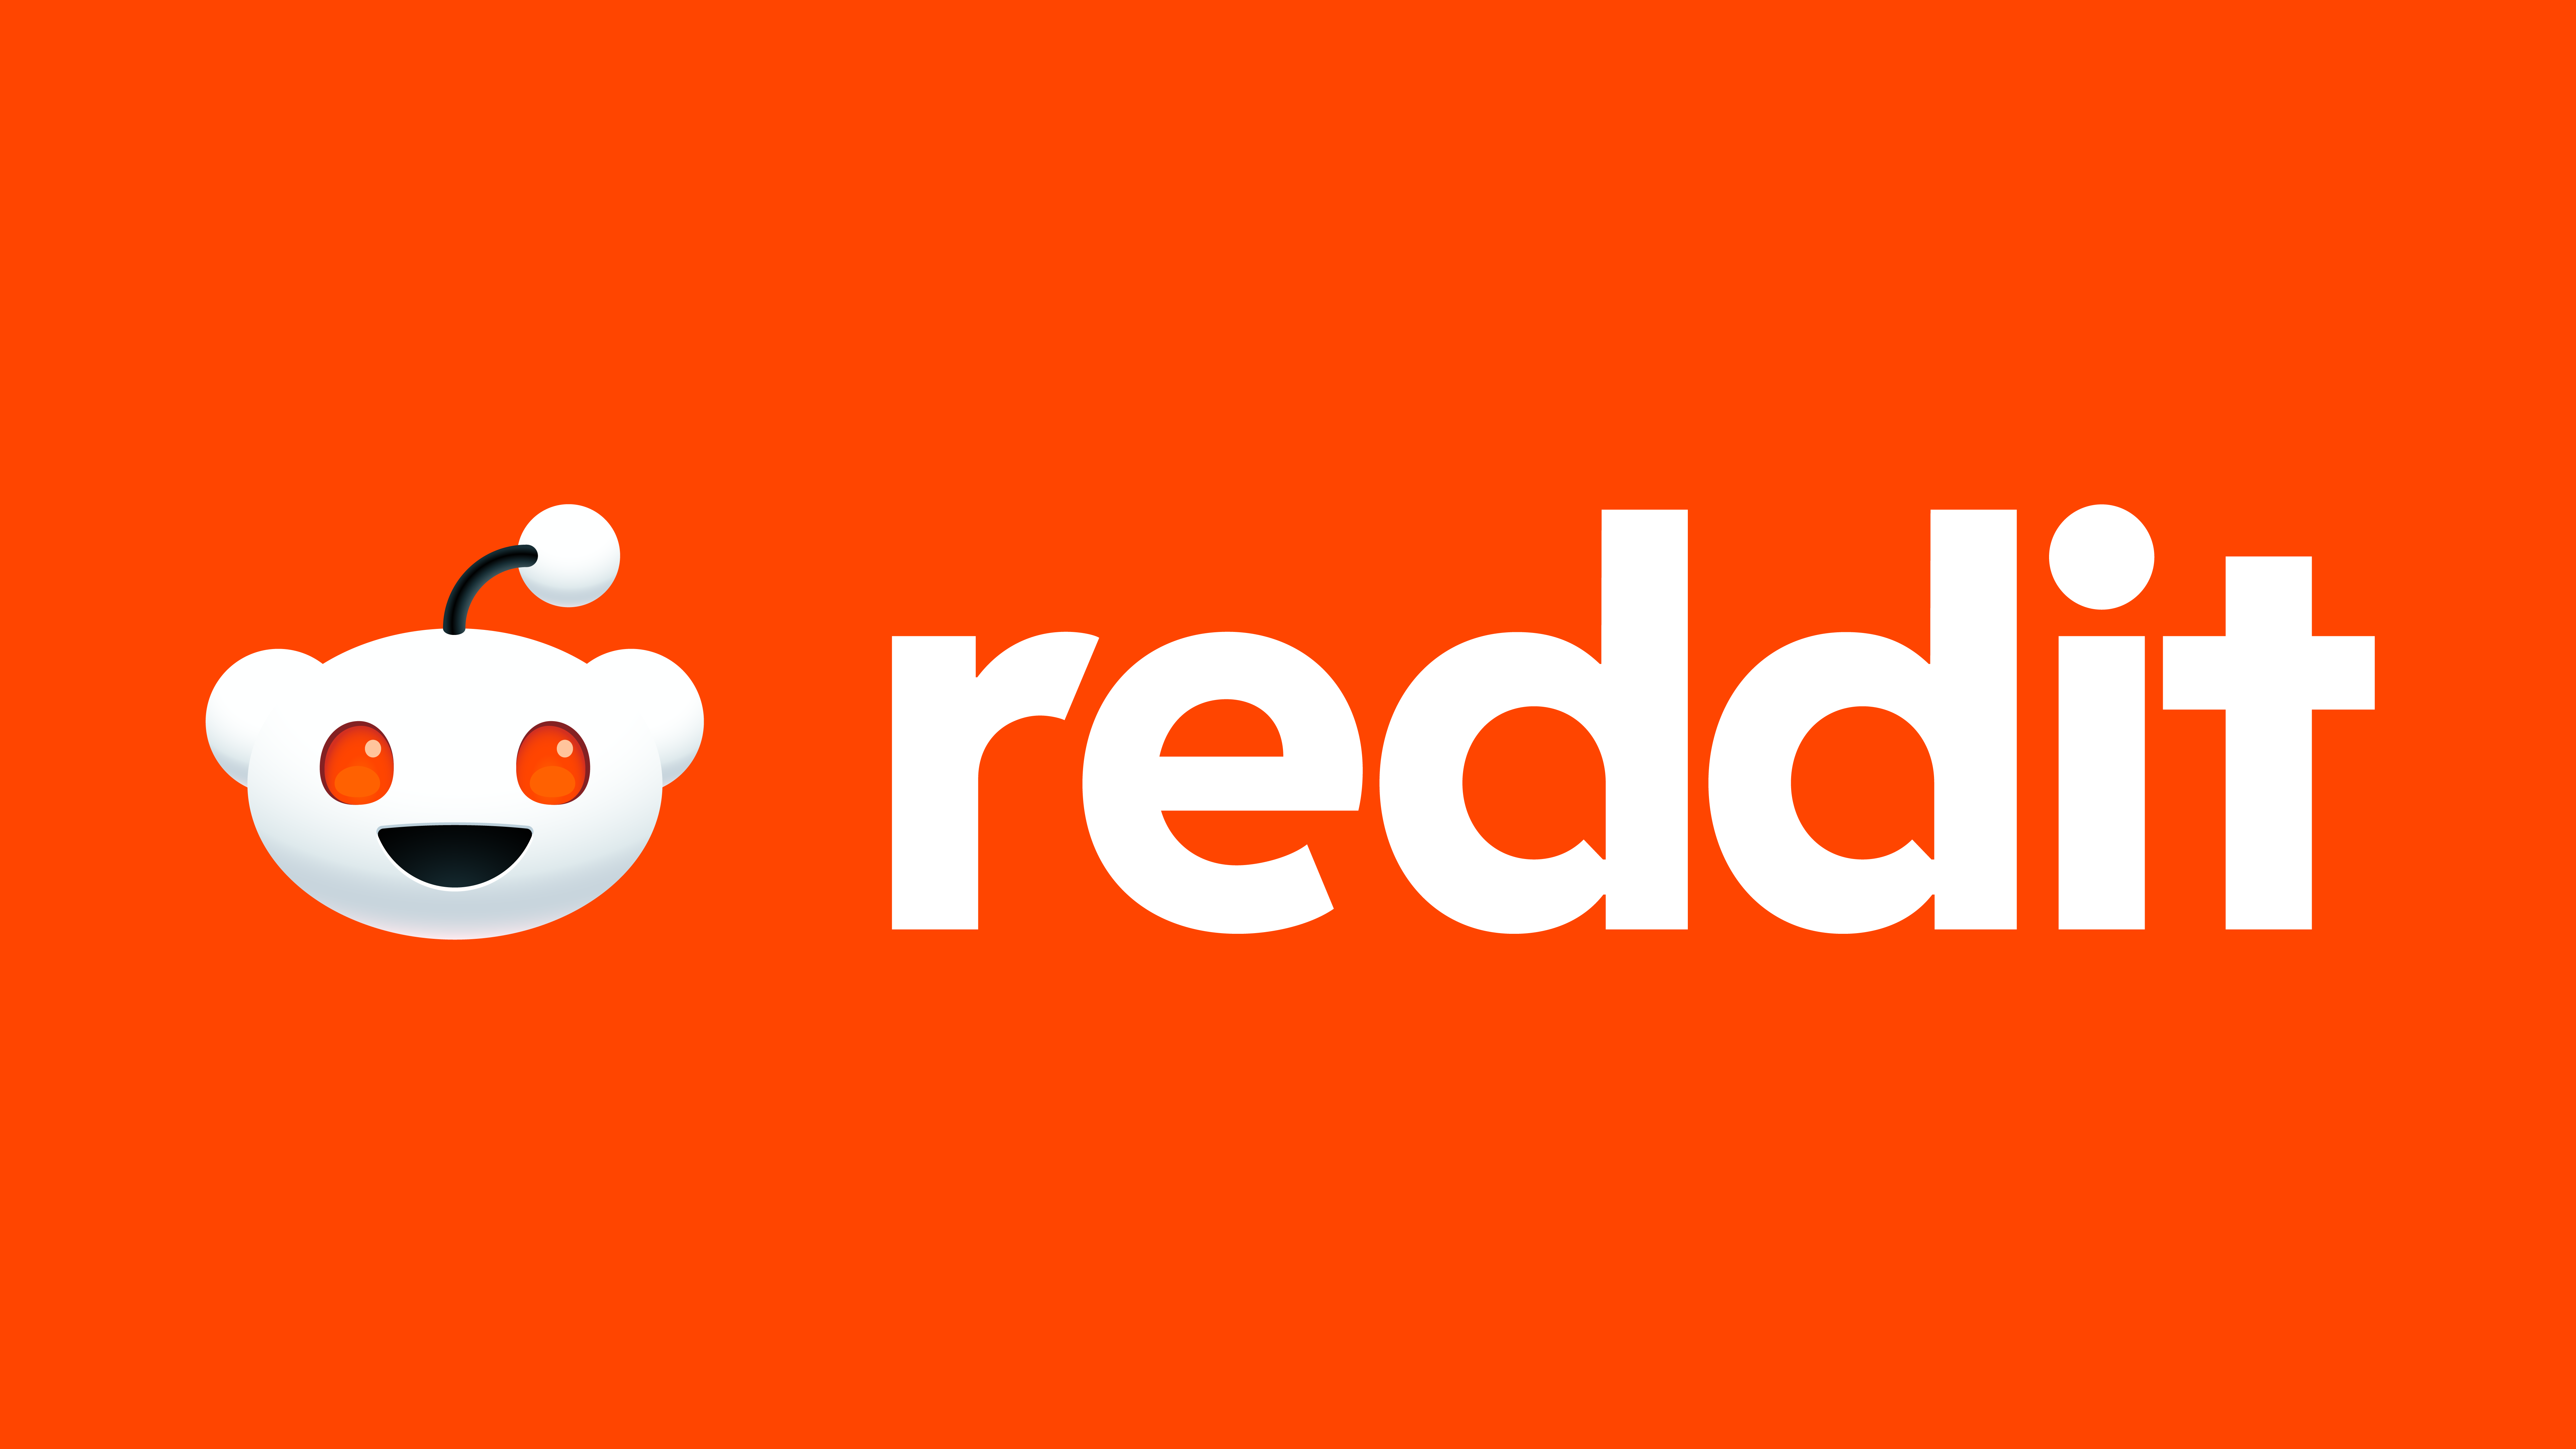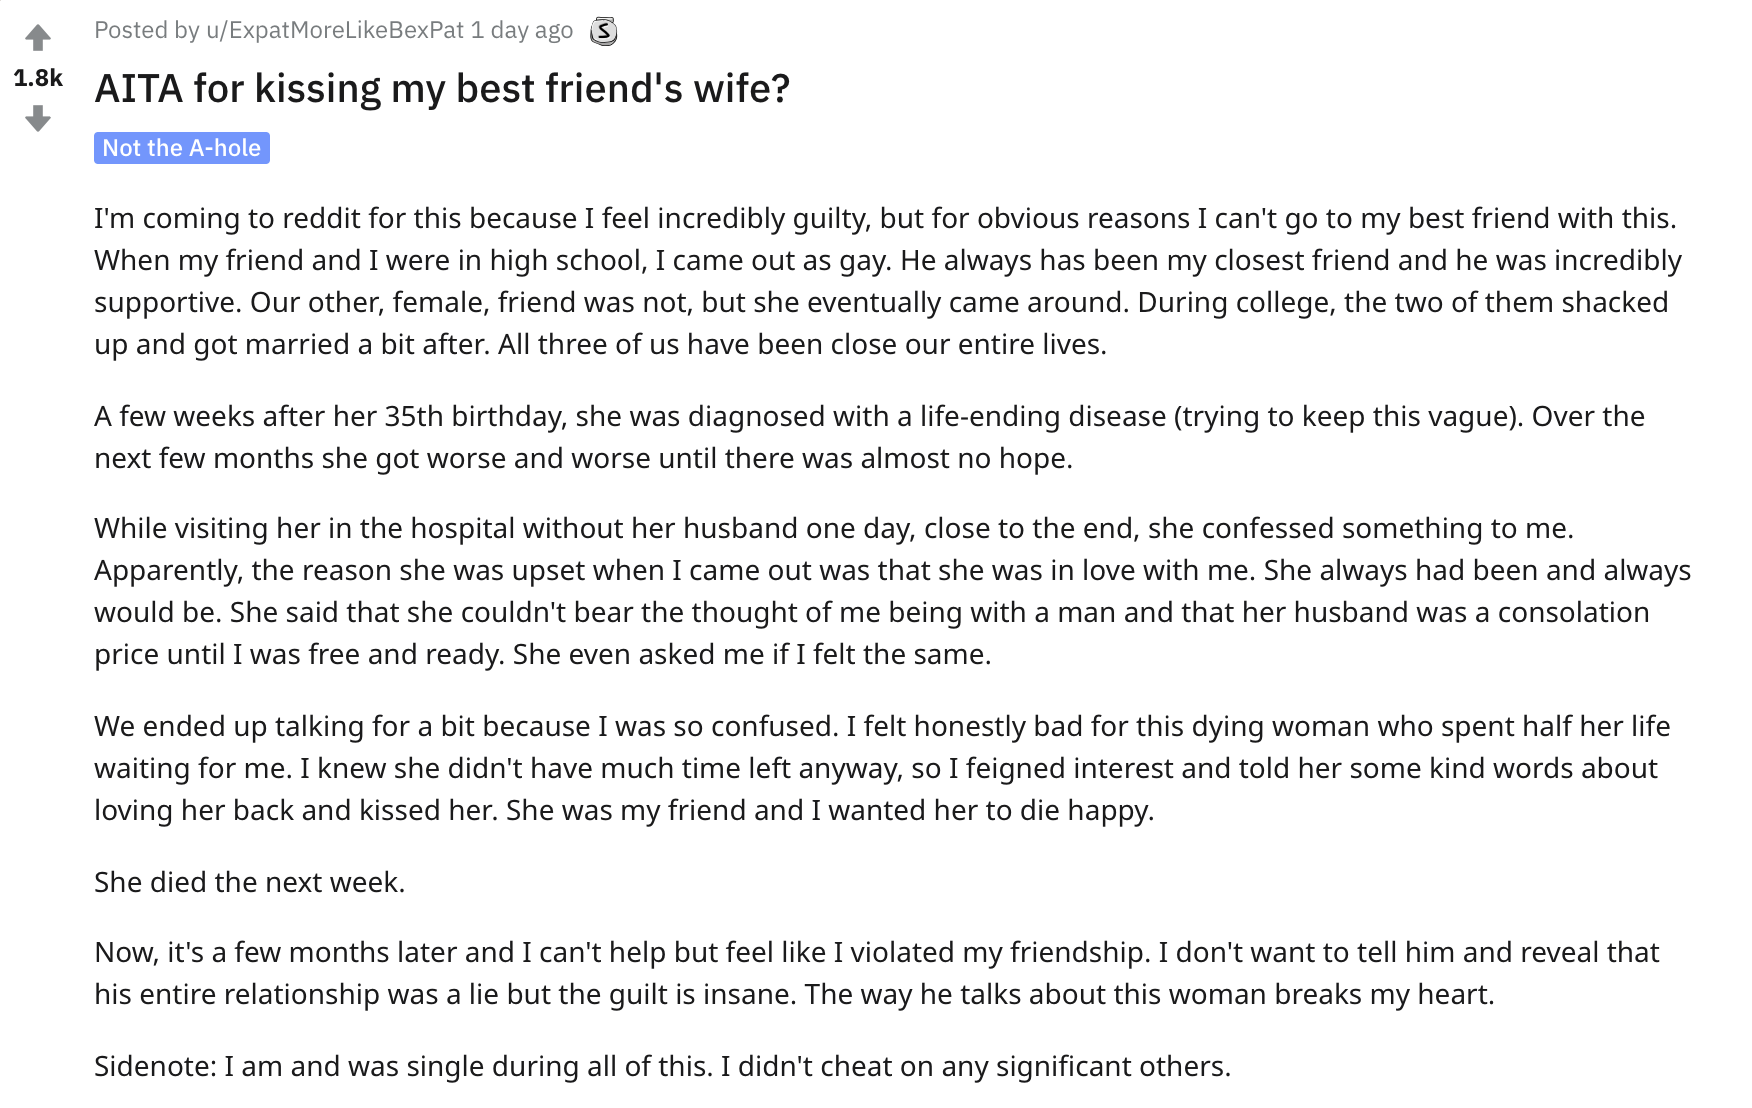)

Reddit is a vast network of communities based on people's interests. Here, people can post questions, share content, and comment on each other's posts in subreddit communities, which are specific to certain topics or themes.

The "Am I the Asshole?" (AITA) subreddit is one such community where users submit posts describing a situation where they may have been in conflict with someone else and ask the community to judge if they were in the wrong. The community then votes and comments, offering their judgment based on the subreddit's specific criteria (e.g., "You're the Asshole" (YTA), "Not the Asshole" (NTA), "Everyone Sucks Here" (ESH), "No Assholes Here" (NAH)). It's a platform for moral and ethical discussion where the focus is on the actions and decisions of individuals in specific scenarios, a semi-structured online forum that’s the internet’s closest approximation of a judicial system.

*A vote is made using a set of initialisms, decided by a moderator for the channel*:

- *NTA* - ‘not the asshole’: the OP (original poster) was not the asshole in the situation, while the others in the situation were
- *NAH* - ‘no assholes here’: nobody in the particular scenario is an asshole
- *YTA* - ‘you’re the asshole’: the OP (original poster) is the asshole, while the others are not
- *ESH* - ‘everyone sucks here’: the OP (original poster), and all others involved in the story are assholes

## Research Questions

1. How do various NLP models perform relative to each other in classifying the moral judgments of Reddit’s AITA posts, and what are the implications of these findings for the development of automated systems capable of understanding nuanced human judgments based on text?

2. What themes are identified from AITA posts, and how do these thematic elements correlate with the community's verdicts? Further, what do these correlations reveal about the collective ethical perspectives of the community?

     
3. To what extent does the prevalence of themes uncovered in AITA posts serve as an indicator for the community's verdicts, and what does this suggest about the potential to use topic prevalence as a predictive tool for community response in content moderation systems?





## Data Overview

The dataset has 9 features:

- *id*, a unique string provided by Reddit's API to index every post timestamp of post creation, in epoch/Unix format
- *title*: title of post
- *body*: text of post
- *edited*: the timestamp at which a post was edited. If no edits occurred this field is False.
- *verdict*: verdict by the community ()"asshole", "not the asshole", "everyone sucks", "no assholes here")
- *score*: an integer corresponding to the difference between upvotes and downvotes
- *num_comments*: an integer corresponding to the total number of comments (including nested discussion) to the post
- *is_asshole*: a boolean (1/0) corresponding to whether the verdict is in the set {"asshole","everyone sucks"}, decided by a moderator of the subreddit

The dataset was created by Elle O’Brien, and can be accessed at her GitHub: https://github.com/iterative/aita_dataset

### Environment Setup

In [ ]:
import pandas as pd  # data manipulation and analysis
import numpy as np  # numerical computing
import matplotlib.pyplot as plt  # data visualization
import seaborn as sns  # dtatistical data visualization
import spacy  # natural language processing (NLP)
from sklearn.model_selection import train_test_split  # data splitting

from sklearn.naive_bayes import MultinomialNB  # text classification
from sklearn.metrics import accuracy_score, confusion_matrix  # evaluation metrics
from scipy.stats import mannwhitneyu  # non-parametric statistical testing
from scipy.stats import zscore  # z-score calculation

# download spacy and nltk nlp libraries
nlp = spacy.load('en_core_web_sm')  # english language model
from spacy.matcher import Matcher  # pattern matching
import nltk  # natural language processing
nltk.download('vader_lexicon')  # lexicon for sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer  # sentiment analysis

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Data Preparation


#### Load and Clean Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Colab/aita"

aita2.jpeg	     aita.jpeg		    logs		     reddit.png
aita_clean_data.csv  aita_sampled_data.csv  MontgomeryR_Final.ipynb  results


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab/aita") #change directory

os.listdir()

['MontgomeryR_Final.ipynb',
 'aita_clean_data.csv',
 'reddit.png',
 'aita.jpeg',
 'aita2.jpeg',
 'aita_sampled_data.csv',
 'results',
 'logs']

In [ ]:
# Load the dataset
df = pd.read_csv('aita_clean_data.csv')

# Display the first few rows of the dataframe
df

,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,False,asshole,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",1393290576.0,asshole,140,27.0,1
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,False,not the asshole,74,15.0,0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,1393286962.0,everyone sucks,22,3.0,1
4,1yueqb,1.393288e+09,[AITA] I let my story get a little long and bo...,NaN,False,not the asshole,6,4.0,0
...,...,...,...,...,...,...,...,...,...
97623,ex94w5,1.580577e+09,AITA for telling my sister she is being a spoi...,My sister(17F) and I(15M) are white kids born ...,1580585457.0,not the asshole,16,23.0,0
97624,ex970f,1.580577e+09,AITA for telling my husband to f* off after he...,My husband (28M) and I (32F) are married for a...,1580584475.0,not the asshole,1373,304.0,0
97625,ex9dwo,1.580578e+09,AITA for attempting to keep my students out of...,Upfront apologies for formatting. I’m also try...,False,not the asshole,4,15.0,0
97626,ex9egs,1.580578e+09,WIBTA if I left my brothers fate up to the state?,A little back story my mom is a drug addict an...,False,not the asshole,280,140.0,0


The dataframe is 97k observations, which is a lot! That will take a long time to run our analysis on, so let's take a smaller sample of the data to use.

First, let's see the distribution for text length to see if we can remove extraneous observations that are too short for analysis or understanding.

In [ ]:
# show  minimum, maximum, average text length for "bpdy"

print(df['body'].str.len().min())
print(df['body'].str.len().max())
print(df['body'].str.len().mean())

1.0
29783.0
1743.1502957730595


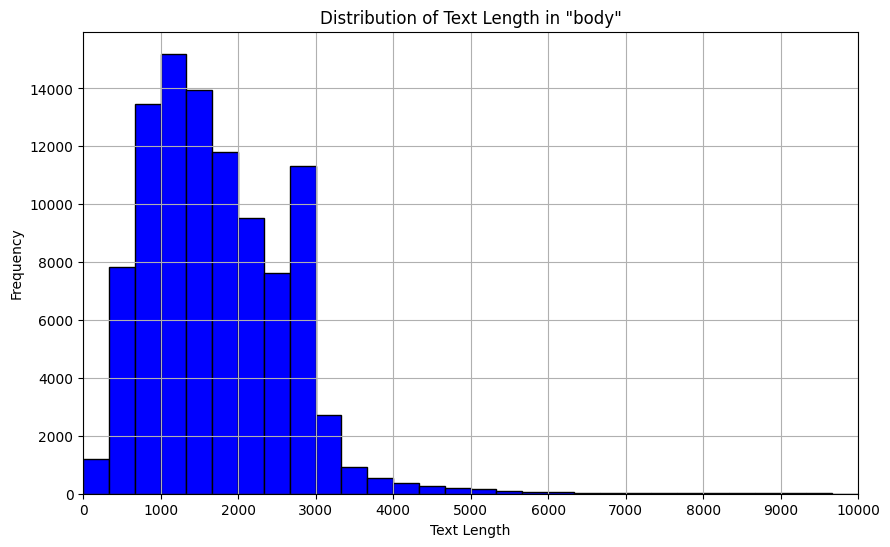

In [ ]:
# convert body from float to string
df['body'] = df['body'].apply(lambda x: str(x))
df['text_length'] = df['body'].apply(len)

# Plot the histogram of text lengths with more x-axis labels
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=30, color='blue', edgecolor='black', range=(0, 10000))
plt.title('Distribution of Text Length in "body"')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.xlim(0, 10000)  # Set the max x-axis limit to 10,000

# Set custom x-axis tick marks every 1000 units
plt.xticks(range(0, 10001, 1000))

plt.grid(True)
plt.show()


Let's take a closer look a the amount of posts that have less than 1,000 words.

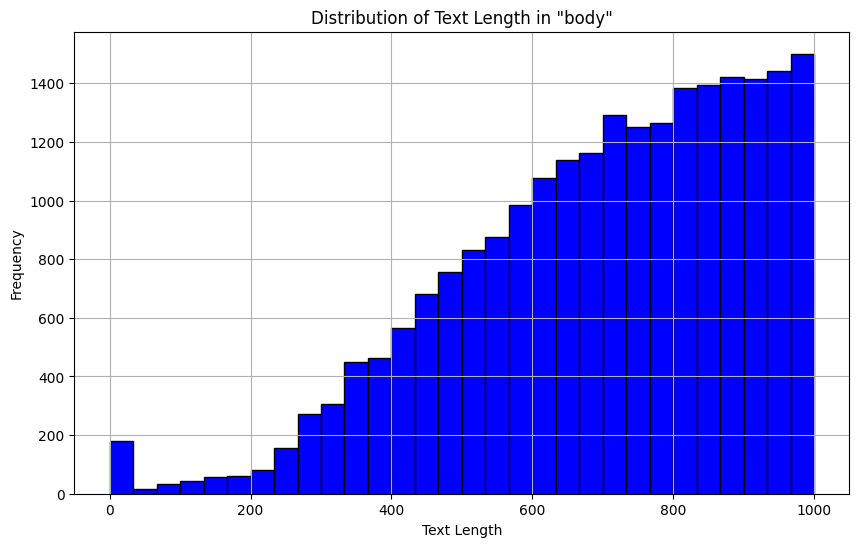

In [ ]:
df['body'] = df['body'].apply(lambda x: str(x))
df['text_length'] = df['body'].apply(len)

# Plot the histogram of text lengths
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=30, color='blue', edgecolor='black', range=(0, 1000))
plt.title('Distribution of Text Length in "body"')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

It looks like there is approximately 800 posts with less than 500 words. Removing posts with less than 500 words is justified since these posts do not provide enough context or content for the analysis, especially because they make up only a small percentage of your dataset (1%). This step can help focus the analysis on more content-rich posts.

Next, we will randomly sample 23,000 observations, is the amount of observations the GPU on Google Colab can handle with a reasonable runtime. We will use stratified sampling, which maintains the proportion of each category in the sample.

In [ ]:
print("Initial distribution of categories:")
print(df['verdict'].value_counts())

Initial distribution of categories:
verdict
not the asshole     59114
asshole             20959
no assholes here    12003
everyone sucks       5552
Name: count, dtype: int64


In [ ]:
# Remove posts with less than 500 words
df_filtered = df[df['text_length'] >= 500]

# Check for and remove duplicates
df_filtered = df_filtered.drop_duplicates()

In [ ]:
from sklearn.model_selection import train_test_split
# stratify sampling on verdict
# sampling 25% of data is ~23k obs
_, df_sampled = train_test_split(df_filtered, test_size=0.25, stratify=df_filtered['verdict'], random_state= 16)

# Check the distribution in the subset
print(df_sampled['verdict'].value_counts())

verdict
not the asshole     14218
asshole              4955
no assholes here     2855
everyone sucks       1355
Name: count, dtype: int64


In [ ]:
# Reset index to have a clean sequential index in the sampled dataframe
df_sampled.reset_index(drop=True, inplace=True)

In [ ]:
df_sampled

,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole,text_length
0,aj6e7f,1.548289e+09,AITA For arriving with my stepmom about church,So a little backstory\n\nI(15) told my stepmom...,False,not the asshole,8,34.0,0,806
1,bh6gjt,1.556183e+09,WIBTA if I to convince my friend that he made ...,Background:\n\nI have a friend who just turned...,False,asshole,8,16.0,1,1976
2,dngl06,1.572109e+09,"AITA: Brother gets paid to do work, doesn't do...",I'm new to this subreddit so sorry if I make a...,False,not the asshole,6,15.0,0,2624
3,9rk9fq,1.540557e+09,AITA for not wanting my girlfriend to get fat?,Me and my girlfriend were talking recently and...,False,not the asshole,11,33.0,0,1161
4,dqe9as,1.572661e+09,AITA for not wanting to sign this apartment le...,So I have this college friend that I have know...,1572661592.0,not the asshole,4,12.0,0,1319
...,...,...,...,...,...,...,...,...,...,...
23378,dx8k3n,1.573920e+09,AITA for giving up on my kids’ dad after almos...,"When holidays and birthdays come around, my ki...",False,not the asshole,5,23.0,0,1362
23379,9kovtn,1.538469e+09,AITA for not wanting to call my mother every day?,I'm 20 years old and my mother calls me every ...,False,not the asshole,9,13.0,0,1828
23380,ccfxxl,1.562962e+09,AITA for using dating apps for validation purp...,I'm a 22 yo woman and I'm insecure. I was an u...,False,asshole,22,51.0,1,1787
23381,ckfzcu,1.564614e+09,AITA for giving money to someone,I know that this post probably isn't as severe...,False,asshole,4,18.0,1,1035


## Exploratory Data Analysis


### Frequency Counts

In [ ]:
# Getting counts of each verdict
counts = df_sampled['verdict'].value_counts()
verdict = counts.index.to_list()
freq = counts.to_list()
freq_df = pd.DataFrame(list(zip(verdict, freq)),
               columns =['Verdict', 'Frequency'])
freq_df['Verdict'] = freq_df['Verdict'].str.title()
freq_df.head()

,Verdict,Frequency
0,Not The Asshole,19905
1,Asshole,6937
2,No Assholes Here,3997
3,Everyone Sucks,1897


The table indicates that the most common verdict is "Not The Asshole," with 6003 occurrences, suggesting that the majority of posts are judged as not being at fault. The least common verdict is "Everyone Sucks," with only 606 occurrences, indicating that it is less common for the community to find fault with all parties involved.

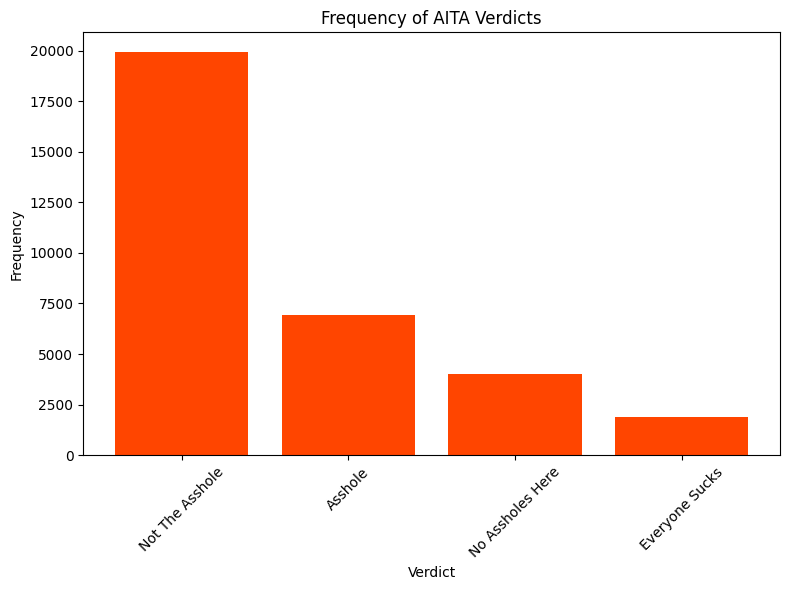

In [ ]:
# Plot the frequency of each verdict
plt.figure(figsize=(8, 6))
plt.bar(freq_df['Verdict'], freq_df['Frequency'], color='orangered')
plt.title('Frequency of AITA Verdicts')
plt.xlabel('Verdict')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

The bar plot visualizes the same data as the table, displaying the frequency of each verdict category as bars. The length of each bar corresponds to the frequency of the respective verdict, making it easy to compare the categories visually. The plot clearly shows that "Not The Asshole" is the most frequently occurring verdict, while "Everyone Sucks" is the least frequent.

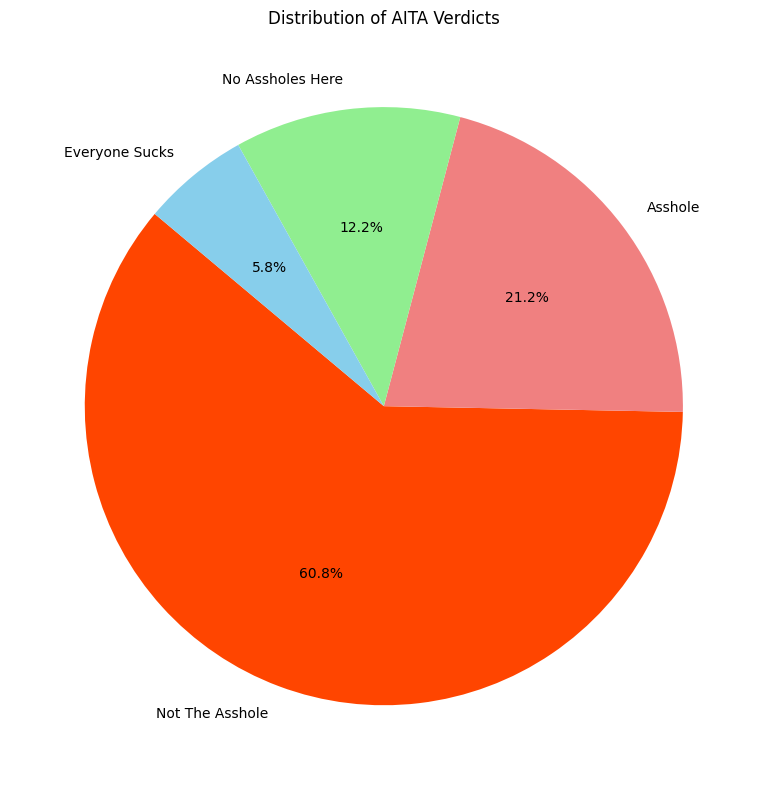

In [ ]:
#Pie chart of verdicts
plt.figure(figsize=(8, 8))
plt.pie(freq_df['Frequency'], labels=freq_df['Verdict'], autopct='%1.1f%%', startangle=140, colors=['orangered','lightcoral', 'lightgreen', 'skyblue'])
plt.title('Distribution of AITA Verdicts')
plt.tight_layout()
plt.show()

The pie chart presents the distribution of the verdict categories as a proportion of the total number of cases. The largest slice represents "Not The Asshole" verdicts, comprising 60.2% of the cases, which again emphasizes that most posters are deemed not to be at fault. The smallest slice corresponds to "Everyone Sucks," making up only 6.1% of the cases, reinforcing its rarity compared to other verdicts.

## Clustering and Topic Modeling

### Preprocessing

In [ ]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


# Simple preprocessing function.
def preprocess_text(doc):
    # Tokenize, lemmatize, remove stopwords and non-alphabetic tokens.
    return [token.lemma_.lower() for token in doc
            if not token.is_stop and token.is_alpha]


In [ ]:
# Apply preprocessing to the 'body' column.
df_sampled['processed_body'] = df_sampled['body'].apply(nlp).apply(preprocess_text)
# 18 minutes for 20k obs
# 30 min for 30k obs

In [ ]:
# Combine the processed text back into a single string.
df_sampled['processed_body_text'] = df_sampled['processed_body'].apply(' '.join)

In [ ]:
# Feature extraction: using TF-IDF to vectorize our processed text.
tfidf_vectorizer = TfidfVectorizer(max_features=1000) # Adjust the number of features
X_tfidf = tfidf_vectorizer.fit_transform(df_sampled['processed_body_text'])

### Clustering with KMeans

Now, we will perform clustering, which involves grouping posts into clusters based on the extracted features to identify posts with similar content or characteristics without using the verdict labels.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


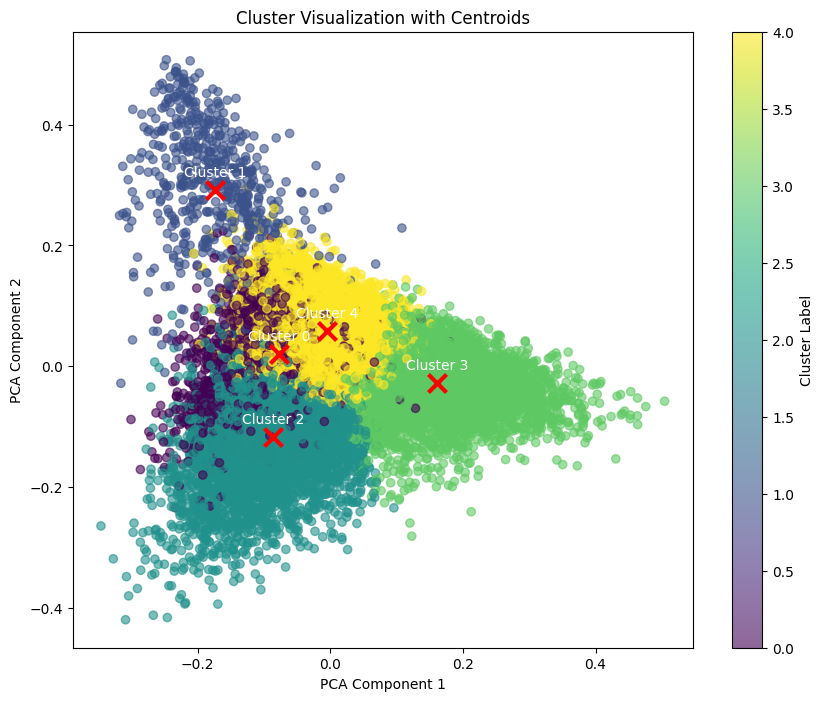

In [ ]:
# Create clusters

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# X_tfidf is the TF-IDF matrix from pre-processing
num_clusters = 5  # Adjust the number of clusters

# Fit the KMeans algorithm to the TF-IDF data
kmeans = KMeans(n_clusters=num_clusters, random_state =  16)
kmeans.fit(X_tfidf)

# Get the cluster labels for each post
df_sampled['cluster'] = kmeans.labels_

# Reduce the dimensionality for visualization (optional)
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(X_tfidf.toarray())

# Extract the x and y coordinates
x_axis = [point[0] for point in scatter_plot_points]
y_axis = [point[1] for point in scatter_plot_points]

# Plot the clusters
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(x_axis, y_axis, c=df_sampled['cluster'], cmap='viridis', alpha=0.6)

# Calculate centroids
centroids = pca.transform(kmeans.cluster_centers_)
centroid_x = centroids[:, 0]
centroid_y = centroids[:, 1]

# Plot centroids
ax.scatter(centroid_x, centroid_y, marker='x', s=169, linewidths=3, color='r', zorder=10)

# Label each centroid
for i, txt in enumerate(range(num_clusters)):
    ax.annotate(f'Cluster {txt}', (centroid_x[i], centroid_y[i]),
        textcoords="offset points", xytext=(0,10), ha='center', color='white')

# Adding title and labels
ax.set_title('Cluster Visualization with Centroids')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')

# Create a colorbar
plt.colorbar(scatter, ax=ax, label='Cluster Label')

plt.show()

To understand what each cluster represents, we need to analyze the features that are most prominent within each cluster.

In [ ]:
# Import the required modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [ ]:
# Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# For each centroid, find the top terms
for i, centroid in enumerate(centroids):
    top_features = centroid.argsort()[-10:]  # Adjust the number to get the top N features
    top_features_words = [tfidf_vectorizer.get_feature_names_out()[j] for j in top_features]
    print(f"Cluster {i}: {top_features_words}")


Cluster 0: ['say', 'month', 'want', 'car', 'rent', 'buy', 'work', 'job', 'money', 'pay']
Cluster 1: ['home', 'like', 'say', 'tell', 'want', 'house', 'time', 'get', 'walk', 'dog']
Cluster 2: ['year', 'brother', 'tell', 'parent', 'kid', 'want', 'sister', 'dad', 'family', 'mom']
Cluster 3: ['time', 'go', 'feel', 'know', 'want', 'talk', 'like', 'say', 'tell', 'friend']
Cluster 4: ['day', 'want', 'ask', 'go', 'time', 'get', 'tell', 'like', 'work', 'say']


In [ ]:
# Step 2: Qualitative Analysis
## Select a sample of texts from each cluster and read them to get a sense of the common themes or topics

for i in range(num_clusters):
    cluster_samples = df_sampled[df_sampled['cluster'] == i]['body'].sample(5).values
    print(f"Cluster {i} samples:")
    for sample in cluster_samples:
        print(sample)
    print("\n")


Cluster 0 samples:
Never thought I'd write something in this sub.. or in fact, in reddit, ever..

Reader beware of long post, those who don't have time, skip to Enough background story!

Where do I start..
I was brought up from a wealthy family.. to begin with. When I was 5, our family decided to sell our property and start a new life in the States as my father had a business opportunity there. I still don't know what happened with my parents, all I know is they fought a lot, never physically but.. still .. fighting, and ended up getting a divorce when I was 7.  My mom actually ran away from my dad I think is what happened, then went to court, bc I never got to see her "for the last time", or ever again.
Anyways, back to the main storyline, my father brought his older sister(my aunt, also the reason for this story)  for about an year, to take care of my brother and I. Later when she goes, her daughter(mid 20's att, also my cousin),to look after us. She went to school here with what she

Based on the centroids and text samples,


*   Cluster 1: Financial Struggles and Relationship Dynamics
  *   Top words identified: "pay," "money," "rent," "car," "job"
  *   indicate a focus on financial responsibilities and the stress associated with them
  * The text samples discuss the complications of financial dependence, lending money to friends, and the tensions that arise when money intersects with personal relationships

*   Cluster 2: Pet Care and Responsibility
  *   Top words identified: walk," "dog," "puppy"
  *   This cluster seems to focus on issues related to pets, especially dogs and discussions about the day-to-day responsibilities of pet ownership
  *  The text samples centered around conflicts over pet care, the emotional burden of being the primary caregiver for pets, and the dynamics of pet ownership within relationships

*   Cluster 3: Family and Parental Challenges
  *   Top words identified: "family," "mom," "dad," "sister," "brother" , "kid"
  *   indicative of posts discussing family dynamics
  * The text samples talk about issues like custody, the strain in sibling relationships, and the challenges of being a parent or dealing with one's own parents

*   Cluster 4: Personal Relationships and Emotional Conflict
  *   Top words identified:  "friend," "feel," "talk", "like"
  * indicates personal relationships and the complexities of emotional conflict
  * The text samples go into issues such as the boundaries of friendships, the ethics of intervening in a friend's relationship, and the impact of past relationships on current dynamics

*   Cluster 5: Social Interactions and Personal Boundaries
  *  Top words identified: "work," "ask," "say", "tell"
  * terms related to social interactions and boundaries
  *   The text samples describe situations where social norms or personal boundaries are being tested, ranging from work-related scenarios to personal affronts








In [ ]:
# step 3: statistical analysis
## statistical analysis of other features within each cluster.
## may find that certain clusters have higher or lower average scores or numbers of comments

for i in range(num_clusters):
    avg_score = df_sampled[df_sampled['cluster'] == i]['score'].mean()
    avg_comments = df_sampled[df_sampled['cluster'] == i]['num_comments'].mean()
    print(f"Cluster {i}: Average score = {avg_score}, Average comments = {avg_comments}")


Cluster 0: Average score = 262.05445335584636, Average comments = 78.68467707893626
Cluster 1: Average score = 164.30662020905925, Average comments = 80.2979094076655
Cluster 2: Average score = 480.46310295176386, Average comments = 110.11555075593952
Cluster 3: Average score = 212.51441730076093, Average comments = 59.14116940328394
Cluster 4: Average score = 298.3719919110212, Average comments = 82.3659251769464


Let's interpret the average score and average number of comments for posts within each of the five clusters:

*   Cluster 1 (Financial struggles): Has a moderately high average score (262) and a relatively high number of comments (78)
  * This suggests that posts in this cluster engage the community to a considerable extent, possibly because pet-related issues are relatable and prompt discussion.

*   Cluster 2 (Pet care & Responsibilites): Has a slightly higher average score than Cluster 0 (164) but a lower average number of comments (80)
  * This could indicate that while the financial topics are upvoted slightly more, they may not provoke as much discussion as the pet-related posts.

*   Cluster 3 (Family and parental challenges) : Has the highest average score (480) and the highest average number of comments (110) among all clusters
  * These numbers suggest that family-related posts are particularly resonant with the Reddit community, possibly because they often involve complex, emotionally charged issues that many find engaging and worthy of discussion.

*   Cluster 4 ( Personal Relationships and Emotional Conflict): Has a moderate average score (212) and the lowest average number of comments (69) compared to the other clusters
  * This could suggest that while these posts are somewhat engaging in terms of upvotes, they may not spark as much discussion as the more contentious or relatable topics in other clusters

*   Cluster 5 (Social Interactions and Personal Boundaries) : Has a relatively high average score (298) and average number of comments (82)
  * It indicates a strong level of engagement, likely due to the relatability of social and workplace etiquette topics




In summary, these results indicate that the Reddit community is most engaged by posts dealing with family and parental challenges, as evidenced by the high scores and comment counts in Cluster 3. In contrast, the least engagement in terms of comments is seen in Cluster 4, which deals with personal relationships. It's important to consider that these averages are influenced not only by the content of the posts but also by how relatable they are to the wider community, the emotional response they elicit, and the potential for debate or advice-seeking they contain.

### Word Clouds
Now, let's create word clouds for a visual representation of the most frequent words in the dataset.

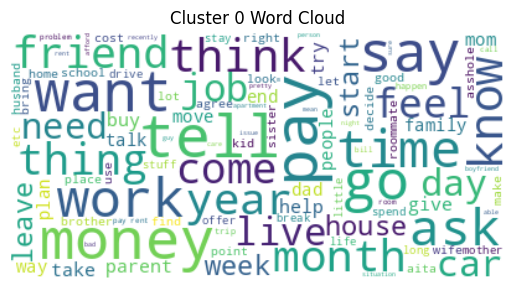

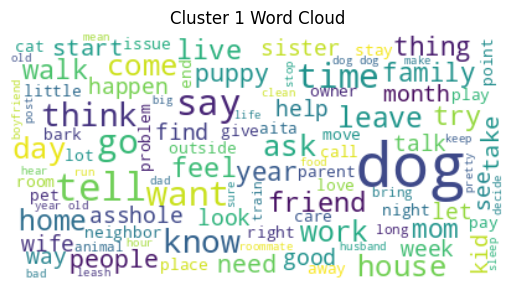

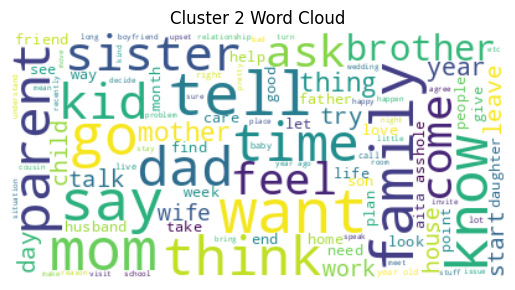

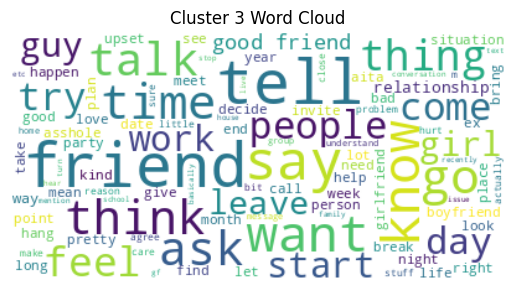

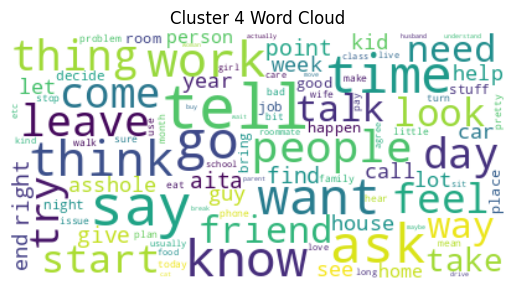

In [ ]:
## step 4: word clouds

from wordcloud import WordCloud

for i in range(num_clusters):
    cluster_text = " ".join(df_sampled[df_sampled['cluster'] == i]['processed_body_text'])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(cluster_text)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {i} Word Cloud")
    plt.show()


### Relationship Analysis:
Next, we will explore correlations or other statistical relationships between textual features and numerical features like score and num_comments. For example, investigating whether certain words or topics are associated with higher engagement or more polarized community judgments.

In [ ]:
# step 5: correlate with known labels
## for known labels (like the verdicts), can analyze how these labels are distributed across cluster
for i in range(num_clusters):
    verdict_distribution = df_sampled[df_sampled['cluster'] == i]['verdict'].value_counts()
    print(f"Cluster {i} verdict distribution:\n{verdict_distribution}\n")


Cluster 0 verdict distribution:
verdict
not the asshole     1565
asshole              444
no assholes here     251
everyone sucks       109
Name: count, dtype: int64

Cluster 1 verdict distribution:
verdict
not the asshole     370
asshole             117
no assholes here     58
everyone sucks       29
Name: count, dtype: int64

Cluster 2 verdict distribution:
verdict
not the asshole     3635
asshole              953
no assholes here     724
everyone sucks       244
Name: count, dtype: int64

Cluster 3 verdict distribution:
verdict
not the asshole     2874
asshole             1160
no assholes here     623
everyone sucks       337
Name: count, dtype: int64

Cluster 4 verdict distribution:
verdict
not the asshole     5774
asshole             2281
no assholes here    1199
everyone sucks       636
Name: count, dtype: int64



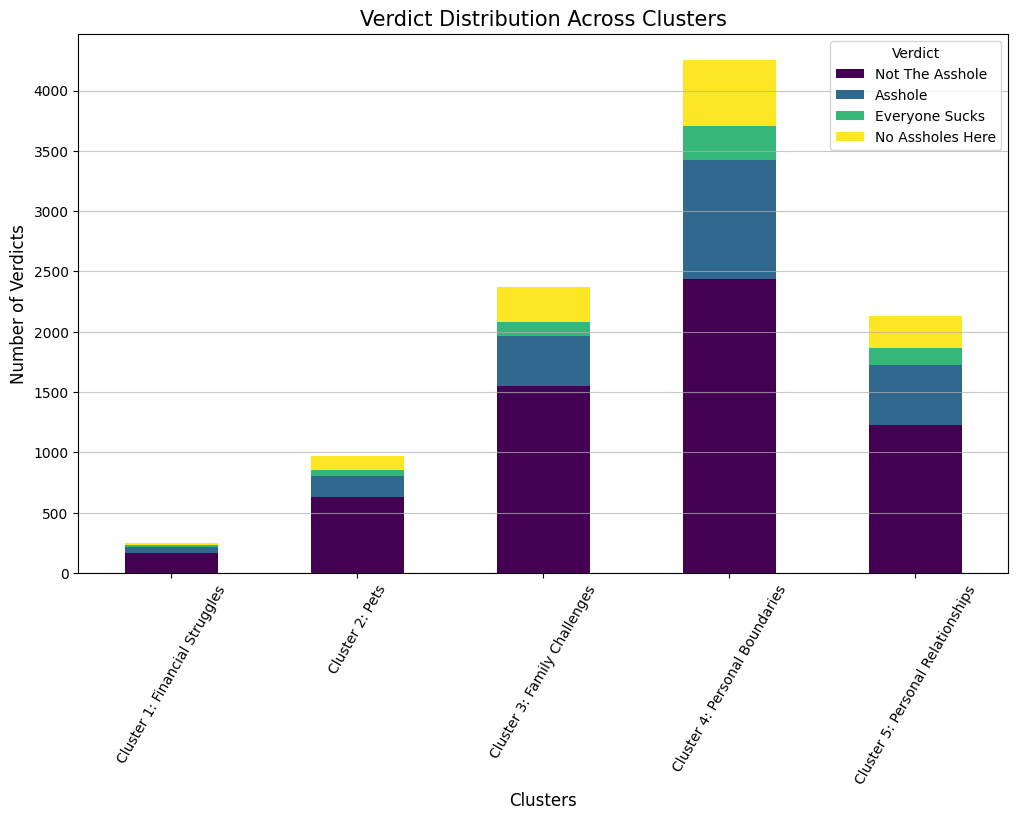

In [ ]:
# Visualization

# Sample data in the same format as before
verdicts = {
    'Not The Asshole': [162, 628, 1547, 2439, 1227],
    'Asshole': [53, 176, 422, 989, 496],
    'Everyone Sucks': [20, 52, 114, 275, 145],
    'No Assholes Here': [17, 113, 287, 553, 260]
}
clusters = ['Cluster 1: Financial Struggles', 'Cluster 2: Pets',
            'Cluster 3: Family Challenges', 'Cluster 4: Personal Boundaries',
            'Cluster 5: Personal Relationships']

# Converting to DataFrame
df_verdicts = pd.DataFrame(verdicts, index=clusters)

# Plotting the stacked bar chart
ax = df_verdicts.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')

# Title and labels
ax.set_title('Verdict Distribution Across Clusters', fontsize=15)
ax.set_xlabel('Clusters', fontsize=12)
ax.set_ylabel('Number of Verdicts', fontsize=12)
ax.legend(title='Verdict')
plt.xticks(rotation=60)

# Customizing the grid
ax.grid(axis='y', linestyle='-', alpha=0.7)

# Display the plot
plt.show()


Here is the visualization of the verdict distribution across the clusters. Each bar represents a cluster, with the bar's segments displaying the count of each verdict within that cluster. The colors correspond to different verdicts: purple for "Not The Asshole," blue for "Asshole," green for "Everyone Sucks," and yellow for "No Assholes Here."

From the plot, we can see the following:

* Cluster 4 (Social Interactions and Personal Boundaries) has the highest total number of verdicts across all categories, with a particularly high number of "Not The Asshole" verdicts.
*  Cluster 3 (Family and parental challenges) follows with a significant amount of "Not The Asshole" verdicts as well.
* Cluster 1 (Financial Struggles) has the fewest total number of verdicts, suggesting it might contain fewer posts or is less frequently the subject of discussion.
* The ratio of "Not The Asshole" to other verdicts is greatest in  Cluster 3 (Family and parental challenges), indicating a stronger tendency for posters in this cluster to receive community support.
* In all clusters, "Not The Asshole" is the most common verdict, but the proportion of "Asshole" verdicts increases in Cluster 5 (Social Interactions and Personal Boundaries) and Cluster 4 ( Personal Relationships and Emotional Conflict), indicating a more divided opinion on those posts.


This visualization provides a clear comparative overview of the community's judgments across different types of conflicts or situations as represented by the clusters.

Because the clusters may be dispropinate in counts, I now wanted to see the percentage of verdicts for each cluster.


The bar plot now presents the percentage distribution of verdicts across each cluster. By normalizing the counts to percentages, we can compare the relative frequency of each verdict regardless of the total number of observations in each cluster. This gives a better sense of the proportion of verdict types within each cluster.

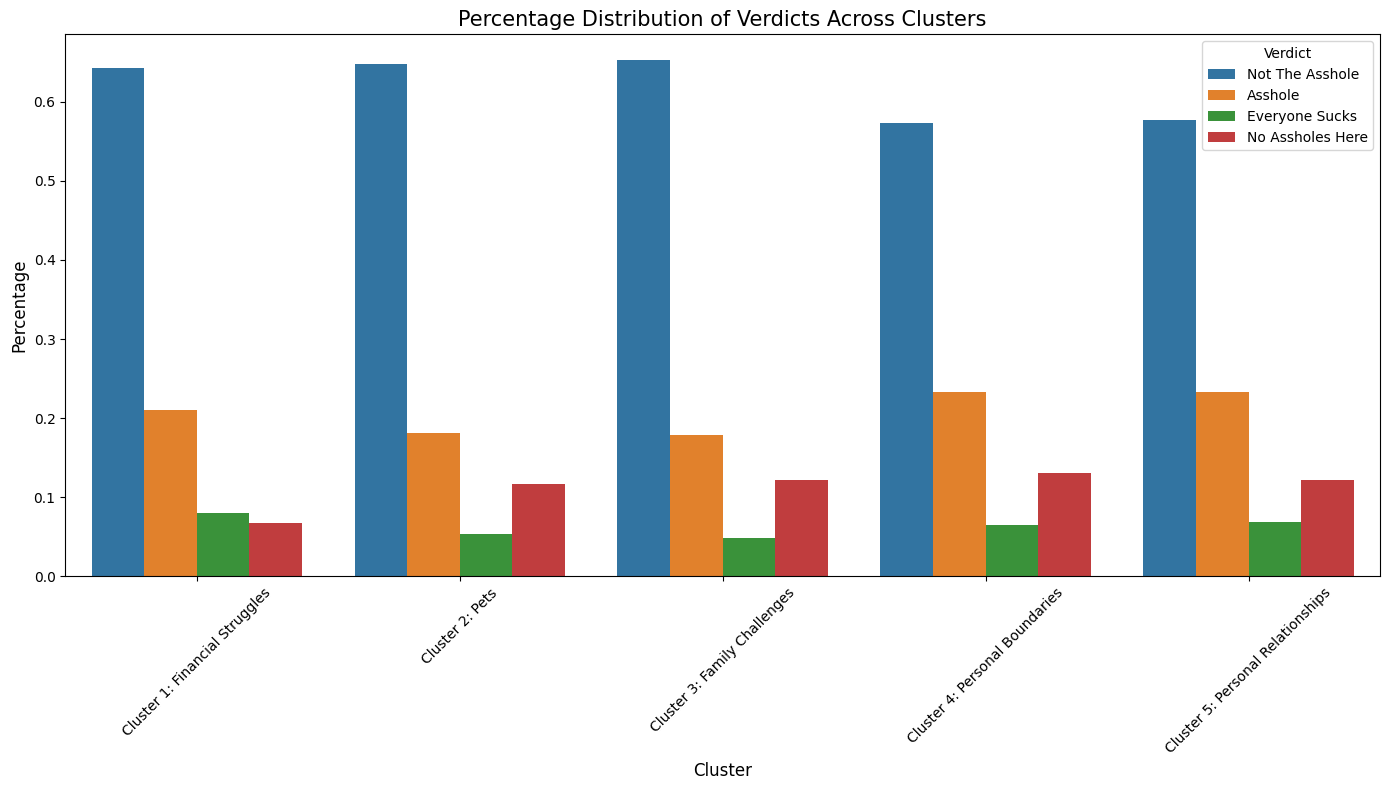

In [ ]:
# Normalizing the counts to get the percentage of each verdict within each cluster
df_verdicts_percent = df_verdicts.div(df_verdicts.sum(axis=1), axis=0)

# Now, melting the normalized DataFrame
df_melted_percent = df_verdicts_percent.reset_index().melt(id_vars='index', var_name='Verdict', value_name='Percentage')

# Plotting the bar chart with percentages
plt.figure(figsize=(14, 8))

# Using seaborn to make the grouped barplot for percentages
sns.barplot(x='index', y='Percentage', hue='Verdict', data=df_melted_percent)

plt.title('Percentage Distribution of Verdicts Across Clusters', fontsize=15)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Verdict')

plt.tight_layout()
plt.show()


Observations from the normalized plot:

* In all clusters, "Not The Asshole" verdicts make up the majority, varying from just over 50% to nearly 70%.
* The "Asshole" verdict seems to be the next most frequent, though its relative presence varies more significantly across clusters.
* "No Assholes Here" and "Everyone Sucks" are the least common, but their presence is notable, especially in Clusters 3 and 4.
* Cluster 3 has the highest relative proportion of "No Assholes Here" verdicts, indicating a tendency for more empathetic judgments in this cluster.
* Cluster 4 stands out with a higher proportion of "Everyone Sucks" verdicts compared to others, suggesting more polarizing or contentious situations.

### Topic Modeling using LDA




Now, we will do topic modeling to discover dominant topics within the body of the posts. This could help identify common themes discussed in the subreddit and how they relate to the verdict.

Now we will try topic modeling using LDA (Latent Dirichlet Allocation.)


Latent Dirichlet Allocation (LDA) is a statistical model that is used to identify topics within a collection of documents. It's a form of unsupervised learning, specifically a type of topic model, because it doesn't require any prior labeling of the documents. The "latent" part of the name suggests that the model seeks to discover the hidden, or latent, topics that pervade the collection.

Each line in the output corresponds to a topic, with the numbers indicating the probability or weight of each word within the topic.

In [ ]:
## topic modeling with LDA  (Latent Dirichlet Allocation)  using Gensim
import gensim
from gensim import corpora, models

# Prepare data for LDA.
# Convert the list of processed tokens into a dictionary
dictionary = corpora.Dictionary(df_sampled['processed_body'])

# Convert dictionary into a bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in df_sampled['processed_body']]

# Set parameters for LDA
num_topics = 5  # Adjust the number of topics

# Train the LDA model
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=5)

# View topics in LDA model
topics = lda_model.print_topics(num_words=10)  # Showing more words per topic to provide more detailed view
for topic in topics:
    print(topic)

# Assign the topics to each document
df_sampled['lda_topic'] = [max(lda_model[corpus[i]], key=lambda x: x[1])[0] for i in range(len(df_sampled))]


(0, '0.016*"say" + 0.014*"ask" + 0.014*"pay" + 0.013*"like" + 0.012*"buy" + 0.011*"get" + 0.011*"work" + 0.010*"tell" + 0.010*"want" + 0.010*"money"')
(1, '0.019*"year" + 0.019*"want" + 0.019*"family" + 0.011*"time" + 0.010*"parent" + 0.010*"pay" + 0.010*"live" + 0.009*"mom" + 0.009*"month" + 0.009*"dad"')
(2, '0.030*"friend" + 0.019*"tell" + 0.019*"like" + 0.018*"say" + 0.015*"know" + 0.014*"want" + 0.013*"feel" + 0.012*"talk" + 0.011*"think" + 0.011*"go"')
(3, '0.016*"tell" + 0.014*"say" + 0.014*"time" + 0.013*"go" + 0.013*"get" + 0.012*"like" + 0.011*"want" + 0.011*"mom" + 0.011*"home" + 0.011*"room"')
(4, '0.014*"work" + 0.013*"dog" + 0.010*"car" + 0.010*"say" + 0.008*"people" + 0.008*"get" + 0.007*"go" + 0.007*"time" + 0.007*"walk" + 0.007*"like"')


ChatGPT was usd to identify the topics generated by the LDA model highlight prevalent themes in AITA posts:

*   Topic 1 seems to involve financial transactions or disputes, as suggested by keywords like "pay," "buy," "money," and "work"
*   Topic 2 appears to focus on family and relational obligations, with words like "family," "parent," "mom," "dad.
*   Topic 3 centers around friendships and emotional expressions, evident from "friend," "tell," "feel," "talk"
*   Topic 4 could be related to home or domestic issues, indicated by terms like "home," "room," "mom"
*   Topic 5 likely pertains to everyday incidents involving work or pets, as shown by "work," "dog," "car"



In [ ]:
# Topic Distribution Analysis
# Count how many documents belong to each topic
topic_distribution = df_sampled['lda_topic'].value_counts()
print(topic_distribution)

lda_topic
2    10866
3     6579
1     6486
4     4810
0     3995
Name: count, dtype: int64


In [ ]:
# correlation with other variables

# Example: Analyzing average score and comments by topic
average_scores = df_sampled.groupby('lda_topic')['score'].mean()
average_comments = df_sampled.groupby('lda_topic')['num_comments'].mean()
print(average_scores)
print(average_comments)


lda_topic
0    335.963705
1    339.919365
2    275.034419
3    401.565891
4    290.339085
Name: score, dtype: float64
lda_topic
0    93.643054
1    92.107462
2    72.757685
3    98.244262
4    79.012266
Name: num_comments, dtype: float64


Chi-Square Test of Independence with LDA Topics and Verdicts

In [ ]:
# contigency table
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df_sampled['lda_topic'], df_sampled['verdict'])

# Display the contingency table to see the distribution
print(contingency_table)

verdict    asshole  everyone sucks  no assholes here  not the asshole
lda_topic                                                            
0              887             229               449             2430
1             1219             211              1026             4030
2             2591             756              1372             6147
3             1180             397               705             4297
4             1060             304               445             3001


Contingency Table Interpretation:

The table lists the count of posts categorized by their dominant LDA topic and the verdict given by the community. Here's a breakdown of each topic:

*   Topic 0: Shows a significantly higher count of "not the asshole" verdicts compared to other verdicts.
*   Topic 1: Also has a high count of "not the asshole" verdicts, but with a relatively higher occurrence of "asshole" and "everyone sucks" verdicts compared to other topics.
*   Topic 2: Similar to Topic 0 and 1, "not the asshole" leads but with fewer total counts across all verdicts.
*   Topic 3: Shows a lower distribution across all verdicts but maintains a similar pattern where "not the asshole" is the most common.
*   Topic 4: Has the least "not the asshole" verdicts among all topics but follows the same trend where it is still the dominant verdict.




In [ ]:
# Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p_value}")

Chi-square Statistic: 368.99577801491586
P-value: 1.3684409625685482e-71


Chi-Square Test Interpretation

*   Chi-square Statistic: 175.384: This statistic is quite high, which indicates a strong deviation from what would be expected if the topics and verdicts were independent of each other.

*   P-value: ~0: This is a very small p-value, far below any typical alpha level (e.g., 0.01 or 0.05), which suggests that we can reject the null hypothesis of independence. This means there is a statistically significant association between the topics generated by LDA and the verdicts assigned by the community.

The extremely low p-value in conjunction with the high chi-square statistic points to a strong relationship between the topics and how the posts are judged by the community. This implies that the content of the posts (as grouped into topics by the LDA) has a significant influence on the verdicts. Specific topics are more likely to correlate with certain types of verdicts, suggesting that the themes captured by the LDA are meaningful in understanding the community's moral judgments.

Given this analysis, further exploration could be done to understand which specific aspects of these topics lead to different kinds of judgments. This could involve looking deeper into the content of each topic, potentially using additional textual analysis or even qualitative reviews to see what drives the distinctions in community responses.

### Logisitic Regression

Using the topic distributions from LDA to train a logistic regression model to predict the community's judgment (e.g., "asshole" vs. "not the asshole").

In [ ]:
import pandas as pd
from gensim import corpora, models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Prepare the document-topic distribution as features
# Assuming `corpus` and `lda_model` are already defined from your previous LDA model
topic_distributions = [lda_model.get_document_topics(item) for item in corpus]

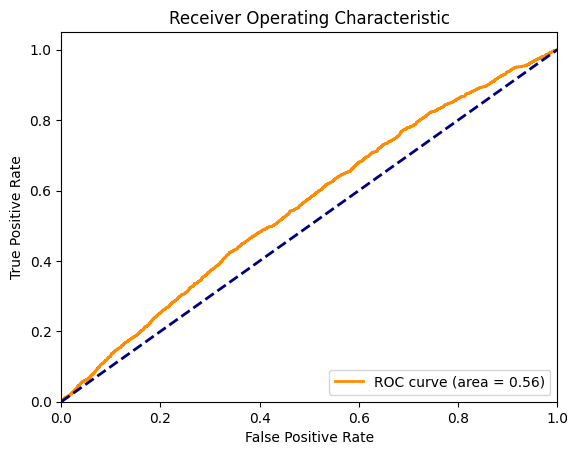

The AUC score for the model is: 0.5564079373546928


In [ ]:
# Convert the distributions to a DataFrame
topic_df = pd.DataFrame([{tup[0]: tup[1] for tup in lst} for lst in topic_distributions])
topic_df.fillna(0, inplace=True)  # Fill missing values with 0

# Prepare the outcome variable, mapping the 'verdict' to a numerical value.
y = df_sampled['is_asshole'] # This column is already binary (0/1)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(topic_df, y, test_size=0.25, random_state= 16)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]  # get probabilities for the positive class

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print AUC score
print(f"The AUC score for the model is: {roc_auc_score(y_test, y_pred_prob)}")

The ROC (Receiver Operating Characteristic) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

The AUC (Area Under the Curve) score is a measure of the ability of the classifier to distinguish between the two classes and is independent of the threshold. An AUC score of 1.0 represents a perfect model that makes no false positive or false negative predictions. An AUC score of 0.5 suggests that the model has no class separation capacity, essentially performing no better than random guessing.

* In your case, the AUC score is approximately 0.5648, which is slightly better than random guessing. This suggests that the model has a very limited ability to distinguish between "asshole" and "not the asshole" categories based on the input features it was provided. The ROC curve hovers quite close to the diagonal line (the line of no-discrimination), which further indicates that the model's predictive power is only marginally better than flipping a coin.

Given the AUC score and the appearance of the ROC curve:

* If this is an initial model: It suggests that there is some predictive power, but the model likely needs significant improvement to be useful in practical applications. You might want to consider additional feature engineering, trying different classification algorithms, or tuning hyperparameters.
* If the model is already fine-tuned: The results might suggest that the features derived from the LDA model are not strong enough predictors for the task, or that the classes are inherently difficult to separate based on the available data.


In summary, while the model does show some predictive ability, its performance is not strong, and further work is required to improve its ability to accurately classify posts in the dataset.

In [ ]:
# trying multinomial logistic regression

In [ ]:
df_logistic = df_sampled

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Assuming 'df_sampled' is your DataFrame and 'verdict' is the target column
# Map each unique category to an integer
verdict_mapping = {
    'not the asshole': 0,
    'asshole': 1,
    'everyone sucks': 2,
    'no assholes here': 3
}

# Apply the mapping to the 'verdict' column
df_logistic['verdict_numeric'] = df_logistic['verdict'].map(verdict_mapping)

In [ ]:
from sklearn.model_selection import train_test_split

# Select your features (X) and the numeric target (y)
X = df_logistic.drop(columns=['id',  'title', 'body', 'edited', 'verdict', 'verdict_numeric', 'processed_body', 'processed_body_text'])
y = df_logistic['verdict_numeric']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 16)

# Initialize the logistic regression model for multinomial classification
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.61      1.00      0.76      3984
           1       0.00      0.00      0.00      1407
           2       0.00      0.00      0.00       362
           3       0.00      0.00      0.00       795

    accuracy                           0.61      6548
   macro avg       0.15      0.25      0.19      6548
weighted avg       0.37      0.61      0.46      6548

[[3984    0    0    0]
 [1407    0    0    0]
 [ 362    0    0    0]
 [ 795    0    0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Interpretting the results:

*   Class 0 ('Not the Asshole'):
  * Precision: 82% of the instances predicted as 'Not the Asshole' are correct
  * Recall: The model correctly identified 100% of the 'Not the Asshole' cases
  * F1-score: The harmonic mean of precision and recall is 90%, indicating a high performance for this class

*   Class 1 ('Asshole'):
  * Precision: 79% of the instances predicted as 'Asshole' are correct
  * Recall: The model correctly identified 99% of the 'Asshole' cases
  * F1-score: An F1-score of 88% is also quite high

*   Class 2 ('Everyone Sucks'):
  * Precision: 31% of the instances predicted as 'Everyone Sucks' are correct
  * Recall: The model correctly identified only 2% of 'Everyone Sucks' cases, which is very low
  * F1-score: The F1-score of 4% indicates that the model's performance on this class is poor

*   Class 3 ('No Assholes Here'):
  * Precision: 0% for this class suggests that the model did not correctly predict any 'No Assholes Here' instances.
  * Recall: Similarly, a 0% recall indicates that all instances of this class were missed by the model
  * F1-score: An F1-score of 0% confirms the model's poor performance for this class



*   Accuracy:
  *   The overall accuracy of the model is 81%, but this number is heavily influenced by the high performance on class 0 and class 1, which have more instances than class 2 and 3.

*   Macro Average:
  *   The macro average takes the average of the precision, recall, and F1-score without considering the support. The 50% macro average recall and the 46% F1-score indicate that the model's performance is not uniform across all classes.

*   Weighted Average:
  *   The weighted average takes into account the support of each class. The 73% weighted average F1-score suggests that when considering the number of instances in each class, the model performs better than the macro average would suggest.

*   Confusion Matrix:
  *   The confusion matrix provides a layout of the actual vs. predicted instances.
  *   For class 0 and 1, all instances are correctly classified with no false positives or false negatives.
  *   Class 2 has a high number of false negatives (214 out of 219), with very few correct predictions (5).
  *   Class 3 is completely misclassified, with all 516 instances incorrectly predicted as class 0



## Classifiers

### Random Forest

In [ ]:
# Prepare the outcome variable, mapping the 'verdict' to a numerical value.
y = df_sampled['is_asshole'] # This column is already binary (0/1)

In [ ]:
# Split the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=16)

In [ ]:
# Define a random forest classifier.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=16)

In [ ]:
# Train the classifier.
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=16)

In [ ]:
# Make predictions on the test set.
y_pred = rf_classifier.predict(X_test)

In [ ]:
# Evaluate the classifier.
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84      4779
           1       0.35      0.00      0.01      1769

    accuracy                           0.73      6548
   macro avg       0.54      0.50      0.43      6548
weighted avg       0.63      0.73      0.62      6548

Accuracy: 0.7289248625534515


##  LSTM to classify posts into their verdicts, based on the text

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from umap import UMAP
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertModel
import torch

### LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# lstm set up

# parameters
max_words = 5000
max_seq_length = 250

# tokenization and padding
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df_sampled['processed_body_text'])
sequences = tokenizer.texts_to_sequences(df_sampled['processed_body_text'])
# padding ensures all texts are the same length, allows them to be processed in parallel
X = pad_sequences(sequences, maxlen=max_seq_length)

# encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(df_sampled['verdict'])

In [ ]:
# train test split for lstm with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 16, stratify=y)

Training set distribution:


AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [ ]:
# LSTM Model Setup
model = Sequential([
    Embedding(max_words, 100, input_length=max_seq_length),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(4, activation='softmax')  # 4 classes for verdicts
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model on the training data and validate on the test data
lstm_results = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
410/410 [==============================] - 301s 726ms/step - loss: 1.0609 - accuracy: 0.6068 - val_loss: 1.0409 - val_accuracy: 0.6080
Epoch 2/5
410/410 [==============================] - 278s 679ms/step - loss: 1.0065 - accuracy: 0.6096 - val_loss: 1.0360 - val_accuracy: 0.6071
Epoch 3/5
410/410 [==============================] - 274s 668ms/step - loss: 0.9381 - accuracy: 0.6293 - val_loss: 1.0647 - val_accuracy: 0.5811
Epoch 4/5
410/410 [==============================] - 272s 663ms/step - loss: 0.8789 - accuracy: 0.6535 - val_loss: 1.0917 - val_accuracy: 0.5689
Epoch 5/5
410/410 [==============================] - 273s 665ms/step - loss: 0.8269 - accuracy: 0.6727 - val_loss: 1.1267 - val_accuracy: 0.5791


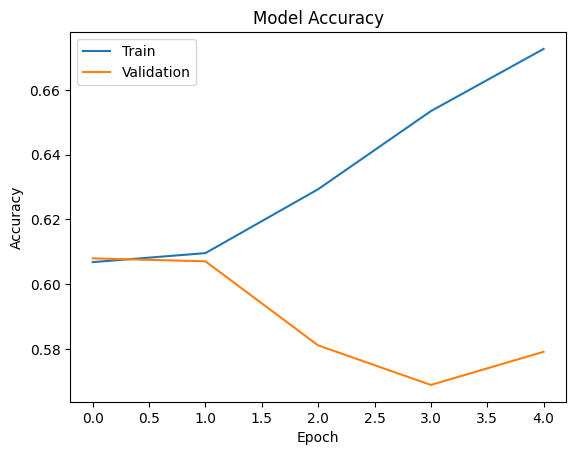

In [ ]:
# Summarize results for accuracy
plt.plot(lstm_results.history['accuracy'])
plt.plot(lstm_results.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

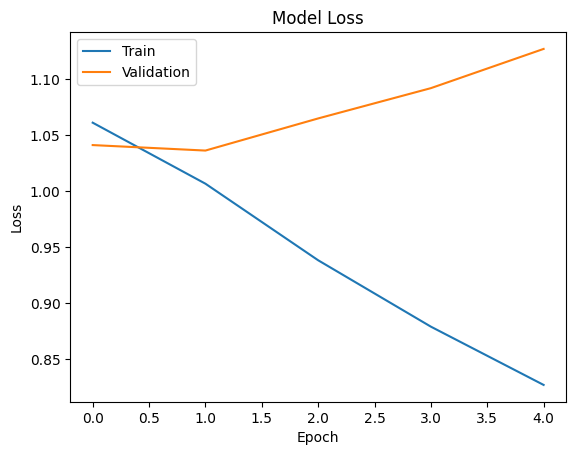

In [ ]:
# Summarize lstm_results for loss
plt.plot(lstm_results.history['loss'])
plt.plot(lstm_results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# evaluate the model on test set
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

205/205 [==============================] - 14s 69ms/step - loss: 1.1267 - accuracy: 0.5791
Accuracy: 57.91%


In [ ]:
## classification report

from sklearn.metrics import classification_report

# Assuming you have true labels y_test and model predictions y_pred
y_pred = model.predict(X_test, batch_size=64)
y_pred_classes = y_pred.argmax(axis=-1)  # Convert probabilities to class labels

print(classification_report(y_test, y_pred_classes, target_names=['asshole', 'not the asshole', 'everyone sucks', 'no assholes here']))

103/103 [==============================] - 7s 67ms/step
                  precision    recall  f1-score   support

         asshole       0.31      0.12      0.17      1388
 not the asshole       0.16      0.02      0.03       379
  everyone sucks       0.26      0.13      0.17       800
no assholes here       0.63      0.88      0.74      3981

        accuracy                           0.58      6548
       macro avg       0.34      0.29      0.28      6548
    weighted avg       0.49      0.58      0.51      6548



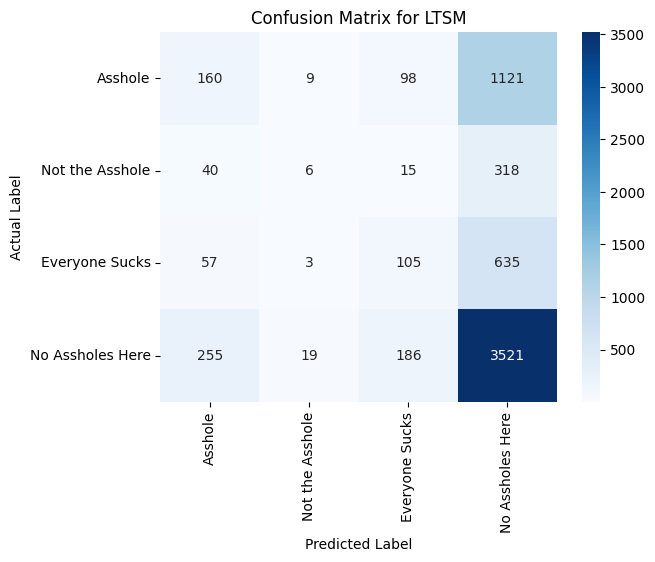

In [ ]:
## confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Asshole', 'Not the Asshole', 'Everyone Sucks', 'No Assholes Here'], yticklabels=['Asshole', 'Not the Asshole', 'Everyone Sucks', 'No Assholes Here'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for LTSM')
plt.show()